### HDR: Neural Network Weights Analysis

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn
import scipy as sp

%matplotlib inline

#### Settings

In [2]:
conn = 'full'  # ['full', 'sparse']

std_X = 'z_score'
std_t = 'max_min'

n_iters  = 100000  # number of iterations per start
n_hidden = 12      # number of neurons in the hidden layer
l_rate   = 1       # learning rate  (0 < l_rate <= 1)

year_s = 2010
year_f = 2016
period = f'{year_s}_{year_f}'

# years = pd.Series(np.arange(year_s, year_f+1))
years = list(np.arange(year_s, year_f+1))

#### Set input/output folder

In [3]:
data_in = f'../data/HDR_3_nn_2a_concat_npy/{conn}/{std_X}__{std_t}/{period}'

data_in_X  = f'../data/HDR_2a_{std_X}_year'
data_in_t  = f'../data/HDR_2a_{std_t}_year'

data_mt   =  '../data/HDR_mutual_attributes_and_countries'

data_out = f'../data/HDR_3_nn_2b_weights_analysis'
if not os.path.exists(data_out):
    os.makedirs(data_out)

plot_out = f'../plots/HDR_3_nn_2b_weights_analysis'
if not os.path.exists(plot_out):
    os.makedirs(plot_out)

#### Read weights

In [4]:
W = dict()

for year in years:
    print(f'Year {year}...', end=' ')
    W[year] = np.load(f'{data_in}/{year}/{n_iters}i_{n_hidden}h_{l_rate}l/W.npy')
    W[year] = np.abs(W[year])
    print('Done!')
    
# Get min and max weights
W_min = min([W[year].min() for year in years])
W_max = max([W[year].max() for year in years])

Year 2010... Done!
Year 2011... Done!
Year 2012... Done!
Year 2013... Done!
Year 2014... Done!
Year 2015... Done!
Year 2016... Done!


#### Read biases

In [5]:
# B_h = dict()
# B_x = dict()

# for year in years:
#     print(f'Year {year}...', end=' ')
#     B_x[year] = np.load(f'{data_in}/{year}/{n_iters}i_{n_hidden}h_{l_rate}l/B_x.npy')
#     B_h[year] = np.load(f'{data_in}/{year}/{n_iters}i_{n_hidden}h_{l_rate}l/B_h.npy')
#     print('Done!')

#### Read outputs

In [6]:
# y = dict()

# for year in years:
#     print(f'Year {year}...', end=' ')
#     y[year] = np.load(f'{data_in}/{year}/{n_iters}i_{n_hidden}h_{l_rate}l/y.npy')[:, :, -1]
#     print('Done!')

#### Read cost function values

In [5]:
C = dict()

for year in years:
    print(f'Year {year}...', end=' ')
    C[year] = np.load(f'{data_in}/{year}/{n_iters}i_{n_hidden}h_{l_rate}l/C.npy')
    print('Done!')

Year 2010... Done!
Year 2011... Done!
Year 2012... Done!
Year 2013... Done!
Year 2014... Done!
Year 2015... Done!
Year 2016... Done!


#### Mutual attributes (2010-2016)

In [7]:
attr = pd.read_csv(f'{data_mt}/attributes_{period}.csv', header=None)
attr = list(attr[0])

print('Total attributes:', len(attr))

Total attributes: 98


#### Mutual countries (2010-2016)

In [8]:
cntr = pd.read_csv(f'{data_mt}/countries_{period}.csv', header=None)
cntr = list(cntr[0])

print('Total countries:', len(cntr))

Total countries: 195


#### Read input data | Input values

In [9]:
X = dict()

for year in years:
    X[year] = pd.read_csv(f'{data_in_X}/{year}.csv', index_col='Country')

    X[year] = X[year][attr]      # mutual attributes
    X[year] = X[year].loc[cntr]  # mutual countries
    X[year] = X[year][X[year].notna()['Human Development Index (HDI)'] == True]

    X[year].replace(0, 1e-9)  # 1/(1,000,000,000)
    X[year] = X[year].fillna(0)  # 0 doesn't contribute to weights

#     print(f'{len(cntr) - X[year].shape[0]} countries are missing HDI value.')

    X[year] = X[year].drop('Human Development Index (HDI)', axis=1)  # input values
#     display(X[year][::10])

#### Read input data | Target values

In [11]:
# t = dict()

# for year in years:
#     t[year] = pd.read_csv(f'{data_in_t}/{year}.csv',
#                           index_col='Country')

#     t[year] = t[year][attr]      # mutual attributes
#     t[year] = t[year].loc[cntr]  # mutual countries
#     t[year] = t[year][t[year].notna()['Human Development Index (HDI)'] == True]

#     t[year].replace(0, 1e-9)  # 1/(1,000,000,000)

#     print(f'{len(cntr) - t[year].shape[0]} countries are missing HDI value.')

#     t[year] = t[year]['Human Development Index (HDI)']  # target values
#     display(t[year][::10])

#### Get list and size of all dimensions

In [10]:
dim_list = [file for file in sorted(os.listdir('../data/HDR_0'))
            if os.path.isdir(f'../data/HDR_0/{file}')]

# for year in years:
#     print(f'===== {year} =====')
#     for dim in dim_list:
#         print(f'- {dim}:', X[year].filter(regex='\[{}\].*'.format(dim)).shape[1])
#     print()

In [11]:
abbrev_dict = {
    'Demography': 'DMG',
    'Education': 'EDU',
    'Environmental Sustainability': 'ENV',
    'Gender': 'GND',
    'Health': 'HLT',
    'Human Security': 'HSC',
    'Income_composition of resources': 'ICR',
    'Inequality': 'IEQ',
    'Mobility and communication': 'MCM',
    'Socio-economic sustainability': 'SES',
    'Trade and financial flows': 'TFF',
    'Work, employment and vulnerability': 'WEV'
}

#### Analysis of the weights

Вредностите на атрибутите ($\vec{\mu}$) за еден случаен старт (random start) се пресметуваат со следната формула:

$$\vec{\mu} = | W_{x, h} \cdot W_{h, y} |$$

- $W_{x, h}$ е матрицата на тежини помеѓу влезниот и скриениот слој
- $W_{h, y}$ е матрицата на тежини помеѓу скриениот и излезниот слој

In [12]:
stats_df = pd.concat([
    pd.DataFrame([W[year][:, :, -1].mean(axis=0) for year in years],
                 index=[f'Mean_{year}' for year in years]) \
                .transpose(),
    pd.DataFrame([np.median(W[year][:, :, -1], axis=0) for year in years],
                 index=[f'Median_{year}' for year in years]) \
                .transpose(),
    pd.DataFrame([np.dot((1 / C[year][:, -1]) / (1 / C[year][:, -1]).sum(), W[year][:, :, -1])
                  for year in years],
                 index=[f'WMean_{year}' for year in years]) \
                .transpose(),
    pd.DataFrame([W[year][:, :, -1].var(axis=0) for year in years],
                 index=[f'Variance_{year}' for year in years]) \
                .transpose(),
    pd.DataFrame([sp.stats.skew(W[year][:, :, -1], axis=0) for year in years],
                 index=[f'Skewness_{year}' for year in years]) \
                .transpose()
], axis=1)

stats_df.index = attr[1:]

# stats_df.style.background_gradient(cmap='Oranges')

##### Mean (%)

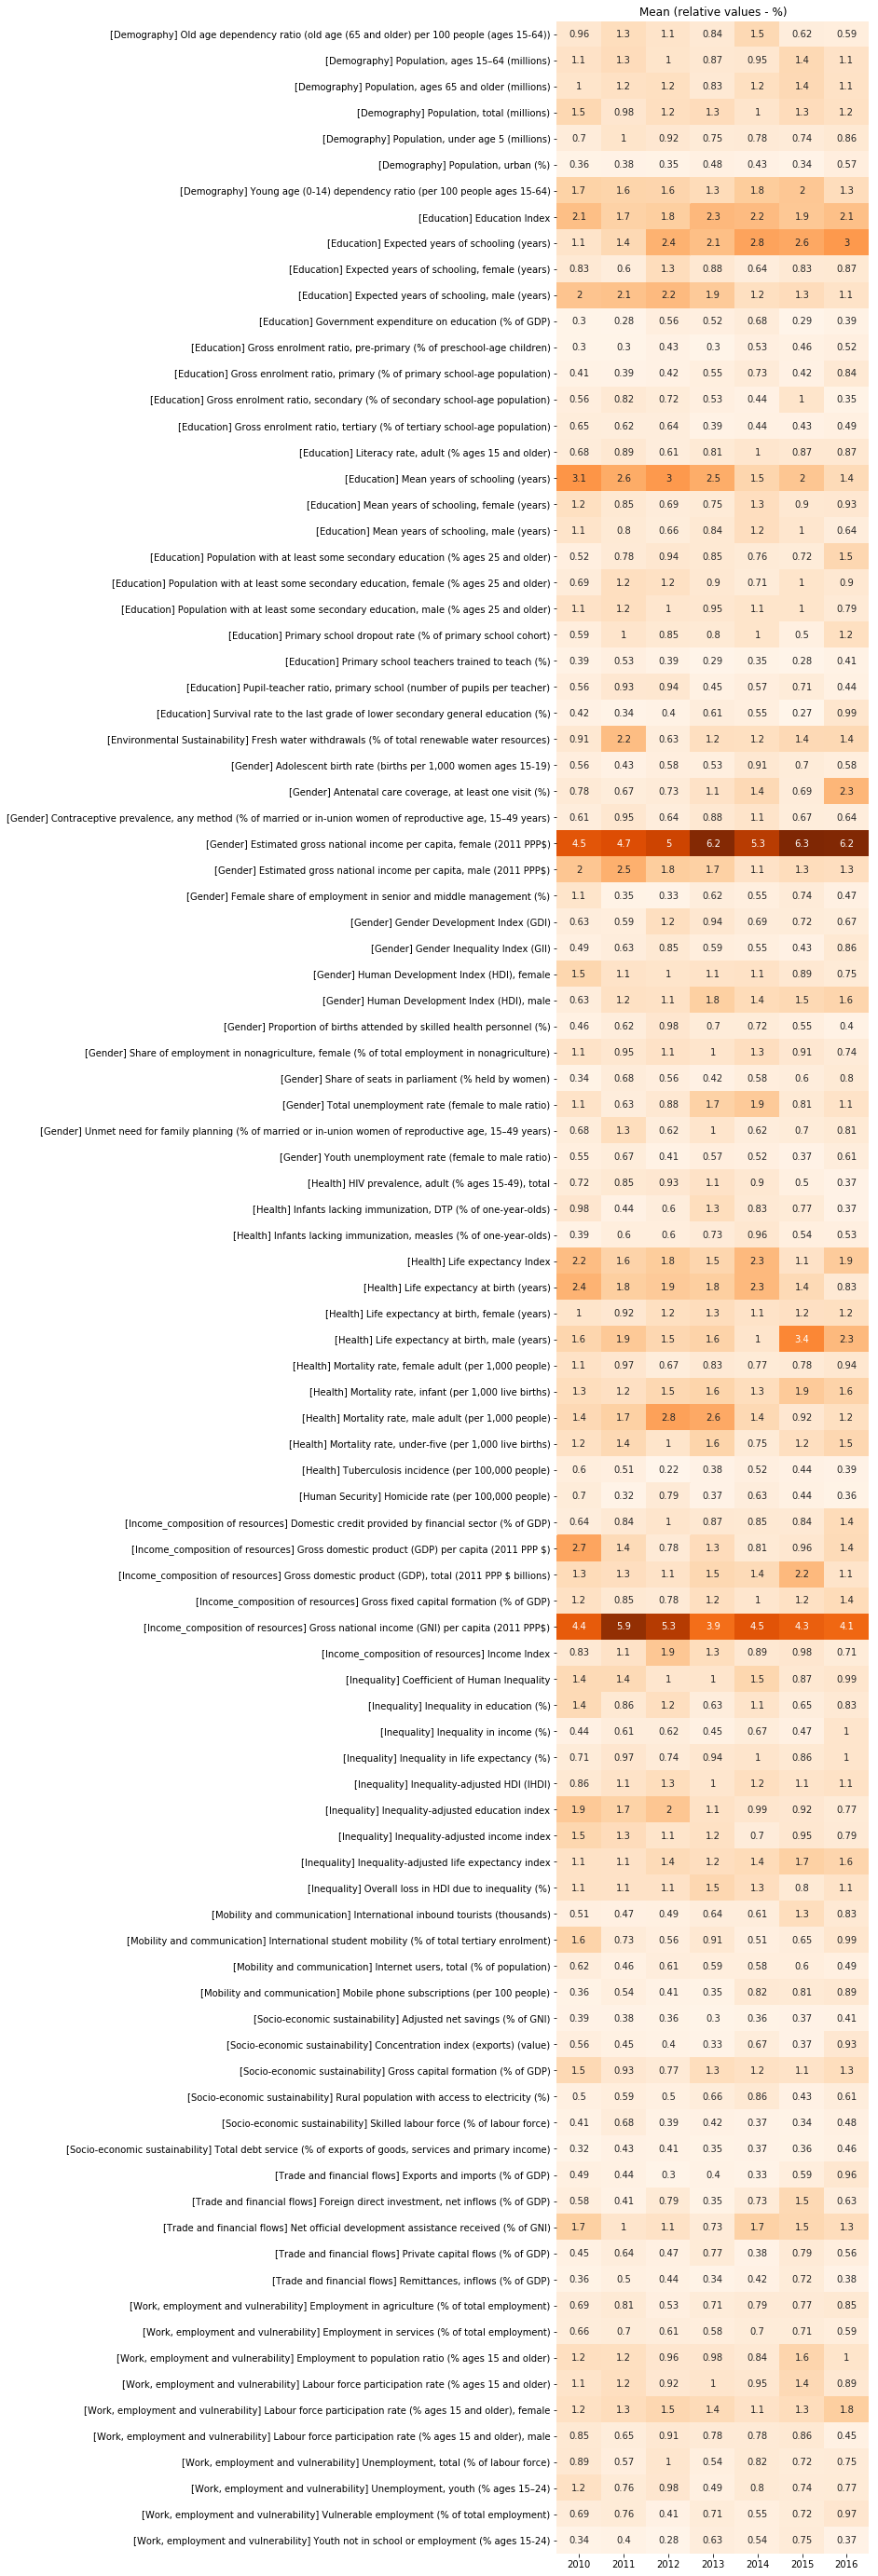

In [13]:
mean_abs_df = stats_df.filter(regex='^Mean')
mean_abs_df.columns = years
mean_abs_df.to_csv(f'{data_out}/mean_abs.csv', index_label='[Dimension] Attribute')

mean_rel_df = mean_abs_df / mean_abs_df.sum() * 100
mean_rel_df.to_csv(f'{data_out}/mean_rel.csv', index_label='[Dimension] Attribute')

plt.figure(figsize=(6, 50))
seaborn.heatmap(mean_rel_df, annot=True, cbar=False, cmap='Oranges')
plt.title('Mean (relative values - %)')
plt.savefig(f'{plot_out}/HDR_mean_rel.png',
            bbox_inches=matplotlib.transforms.Bbox([[-8, 5], [6, 45]]))
plt.show()

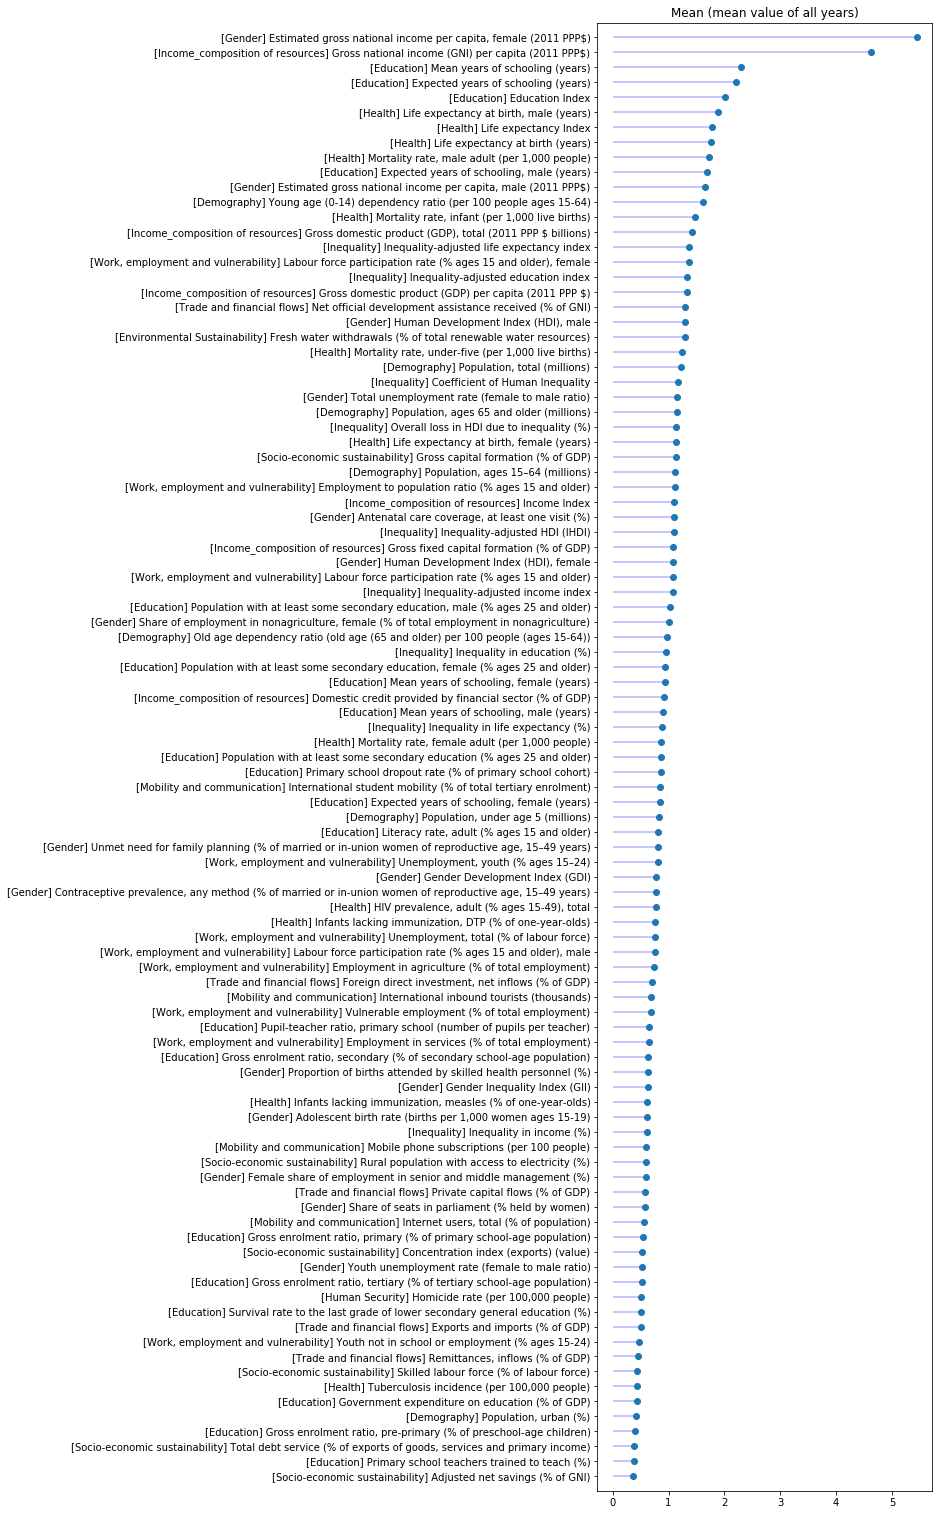

In [14]:
mean_sorted_series = mean_rel_df.mean(axis=1).sort_values()

plt.figure(figsize=(6, 27))
plt.plot(mean_sorted_series.values, mean_sorted_series.index, 'o')

# plt.xticks(mean_sorted_series.index, rotation=90)
# plt.yticks(mean_sorted_series.index)

for i in range(len(mean_sorted_series)):
    plt.hlines(i, xmin=0, xmax=mean_sorted_series.iloc[i], alpha=0.3, color='blue')

plt.margins(0.05, 0.01)
plt.title('Mean (mean value of all years)')
plt.savefig(f'{plot_out}/HDR_mean_mean.png',
           bbox_inches=matplotlib.transforms.Bbox([[-8, 2.5], [6, 24.5]]))
plt.show()

##### Median (%)

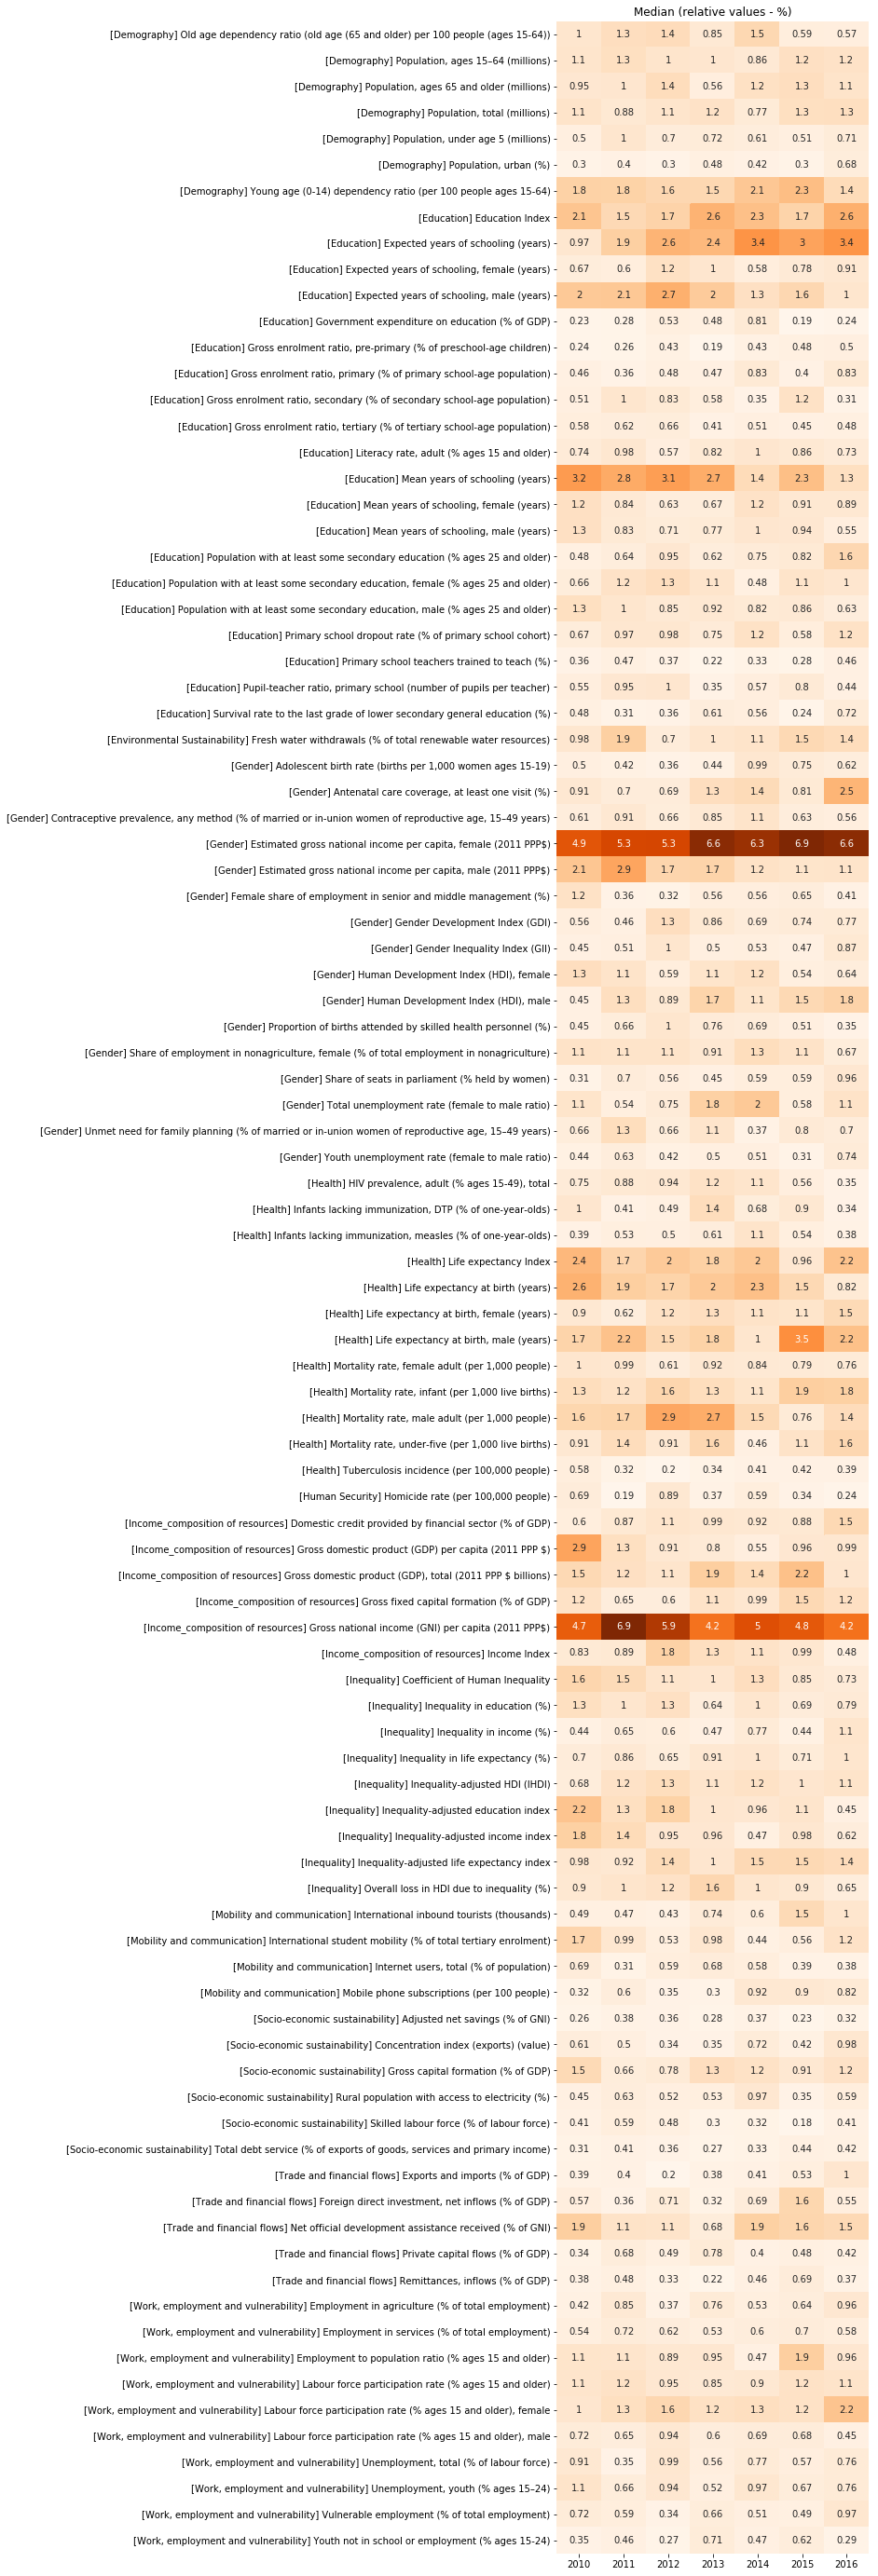

In [15]:
median_abs_df = stats_df.filter(regex='Median')
median_abs_df.columns = years
median_abs_df.to_csv(f'{data_out}/median_abs.csv', index_label='[Dimension] Attribute')

median_rel_df = median_abs_df / median_abs_df.sum() * 100
median_rel_df.to_csv(f'{data_out}/median_rel.csv', index_label='[Dimension] Attribute')

plt.figure(figsize=(6, 50))
seaborn.heatmap(median_rel_df, annot=True, cbar=False, cmap='Oranges')
plt.title('Median (relative values - %)')
plt.savefig(f'{plot_out}/HDR_median_rel.png',
            bbox_inches=matplotlib.transforms.Bbox([[-8, 5], [6, 45]]))
plt.show()

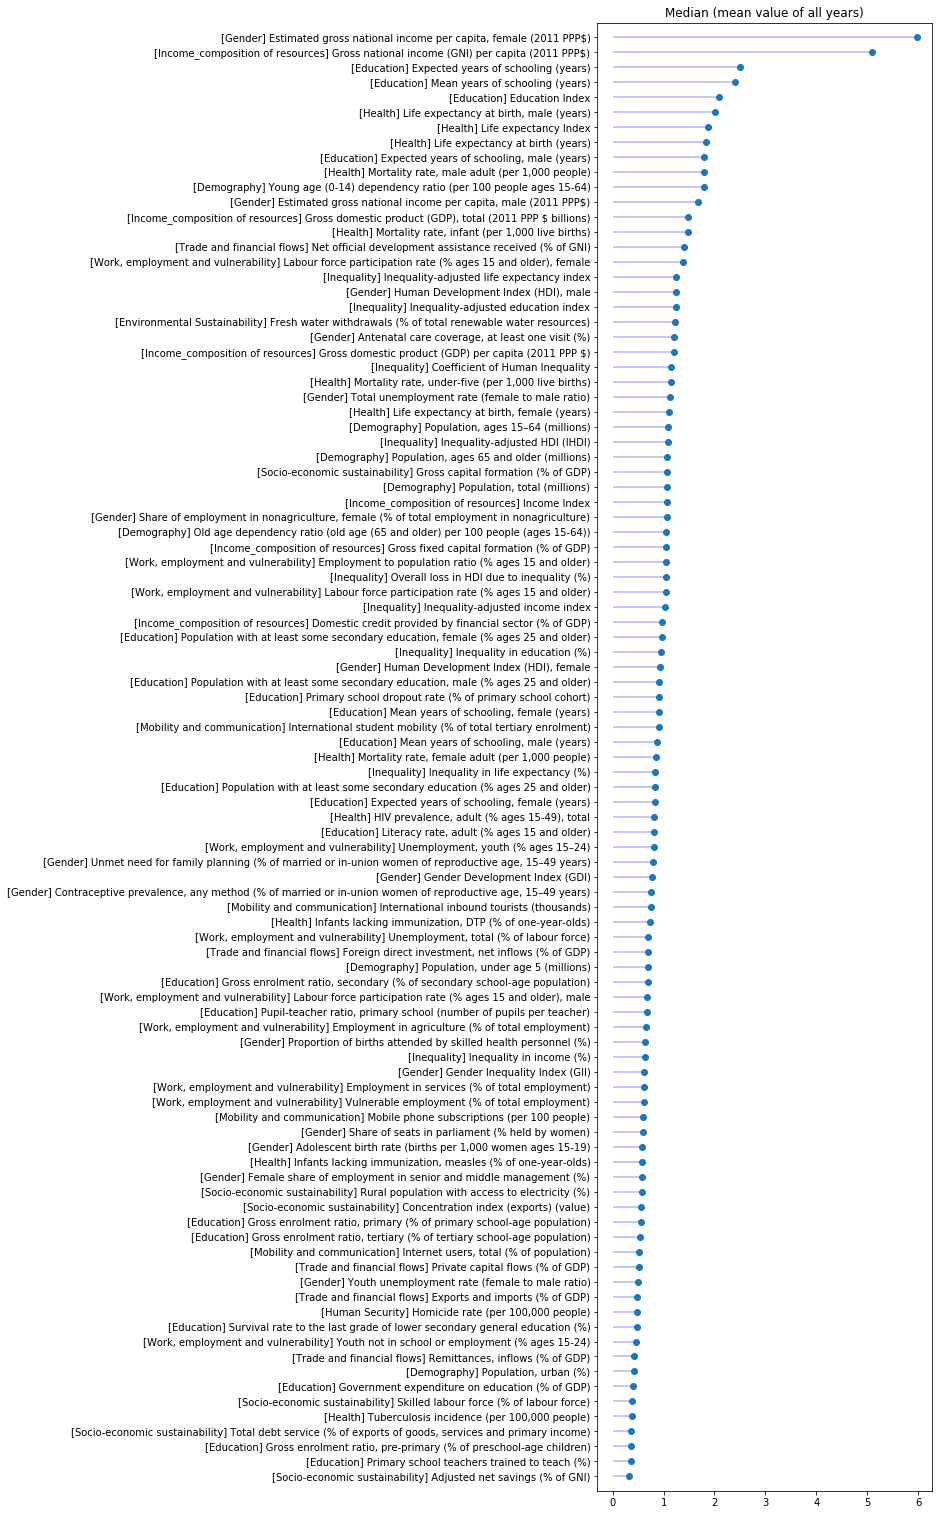

In [16]:
median_sorted_series = median_rel_df.mean(axis=1).sort_values()

plt.figure(figsize=(6, 27))
plt.plot(median_sorted_series.values, median_sorted_series.index, 'o')

for i in range(len(mean_sorted_series)):
    plt.hlines(i, xmin=0, xmax=median_sorted_series.iloc[i], alpha=0.3, color='blue')

plt.margins(0.05, 0.01)
plt.title('Median (mean value of all years)')
plt.savefig(f'{plot_out}/HDR_median_mean.png',
           bbox_inches=matplotlib.transforms.Bbox([[-8, 2.5], [6, 24.5]]))
plt.show()

##### Weighted Mean (%) | Loss-function values are needed!

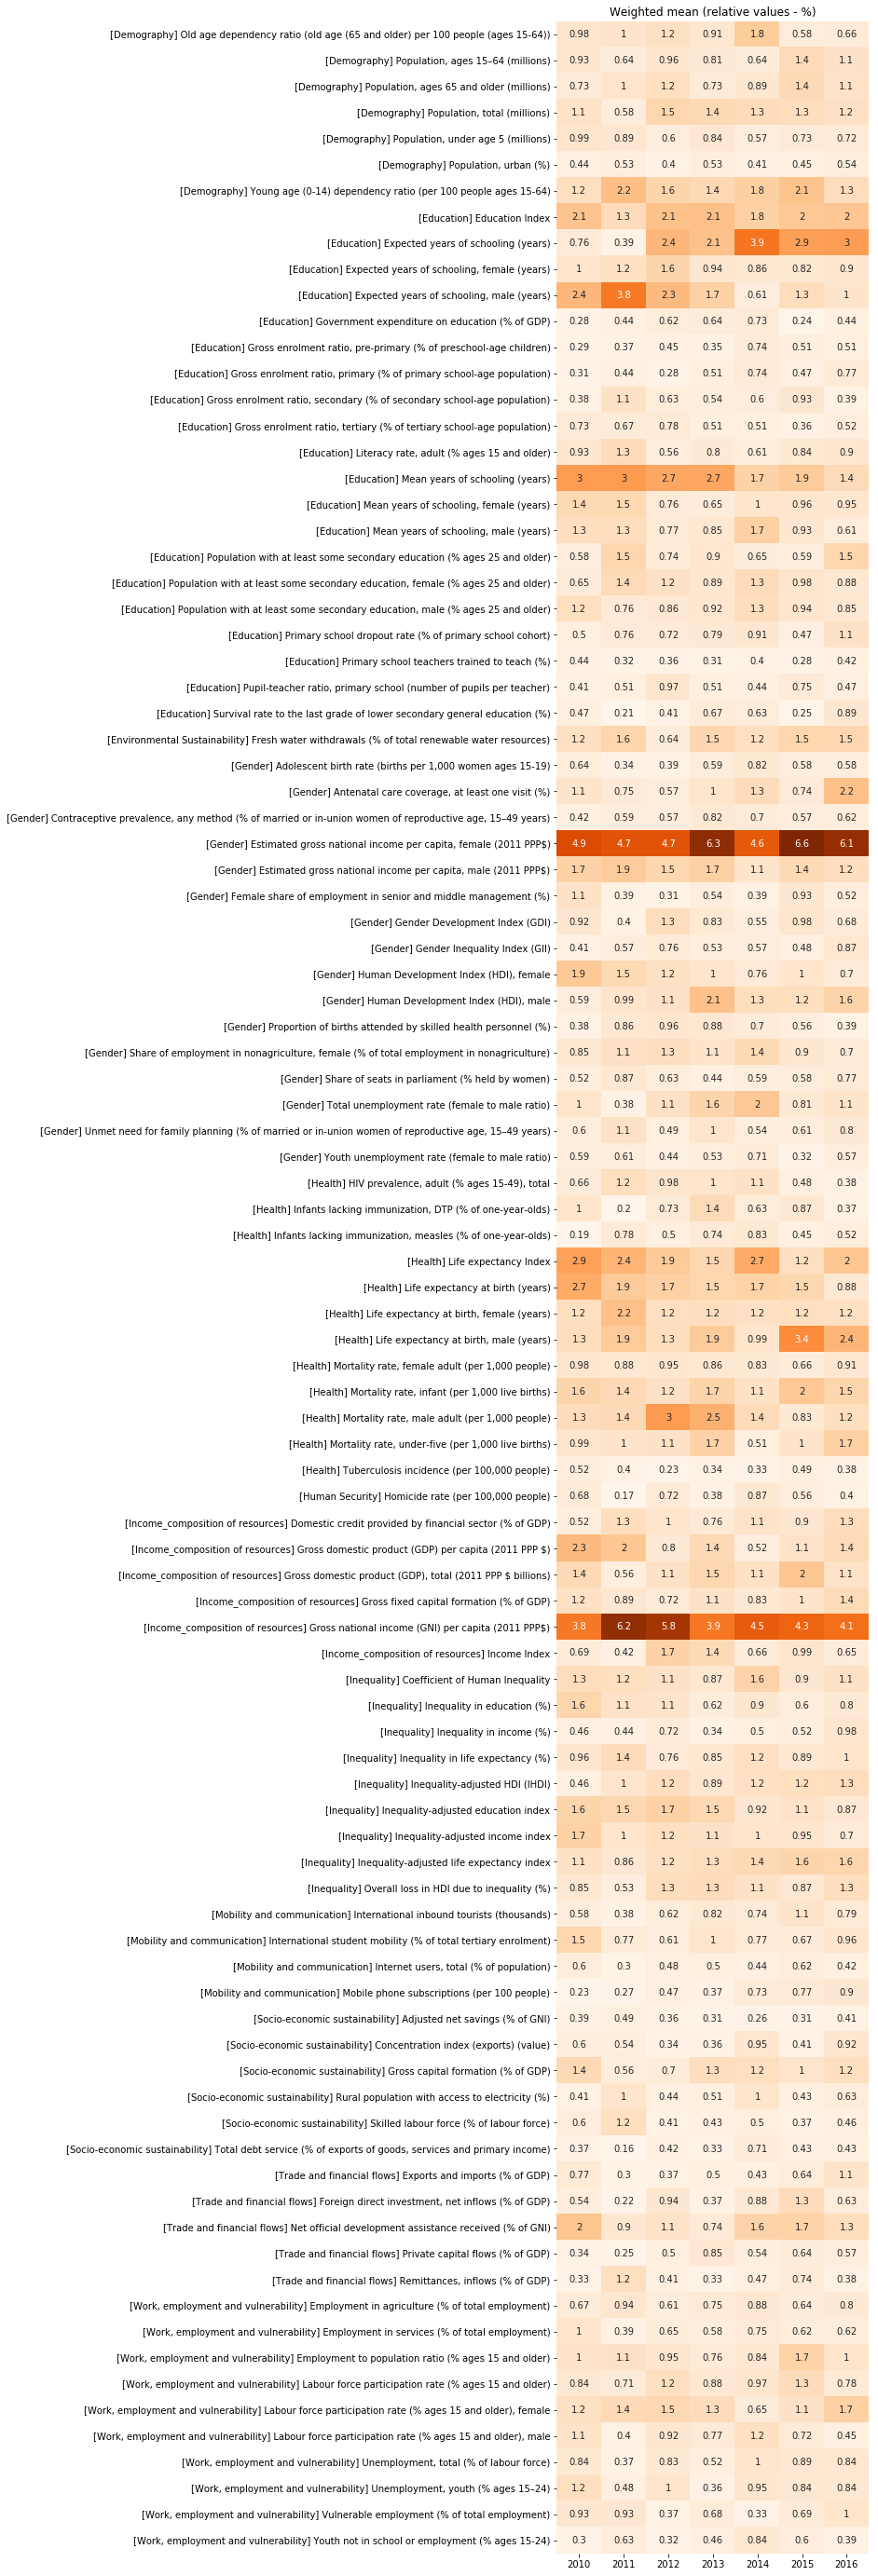

In [17]:
wmean_abs_df = stats_df.filter(regex='WMean')
wmean_abs_df.columns = years
wmean_abs_df.to_csv(f'{data_out}/wmean_abs.csv', index_label='[Dimension] Attribute')

wmean_rel_df = wmean_abs_df / wmean_abs_df.sum() * 100
wmean_rel_df.to_csv(f'{data_out}/wmean_rel.csv', index_label='[Dimension] Attribute')

plt.figure(figsize=(6, 50))
seaborn.heatmap(wmean_rel_df, annot=True, cbar=False, cmap='Oranges')
plt.title('Weighted mean (relative values - %)')
plt.savefig(f'{plot_out}/HDR_wmean_rel.png',
            bbox_inches=matplotlib.transforms.Bbox([[-8, 5], [6, 45]]))
plt.show()

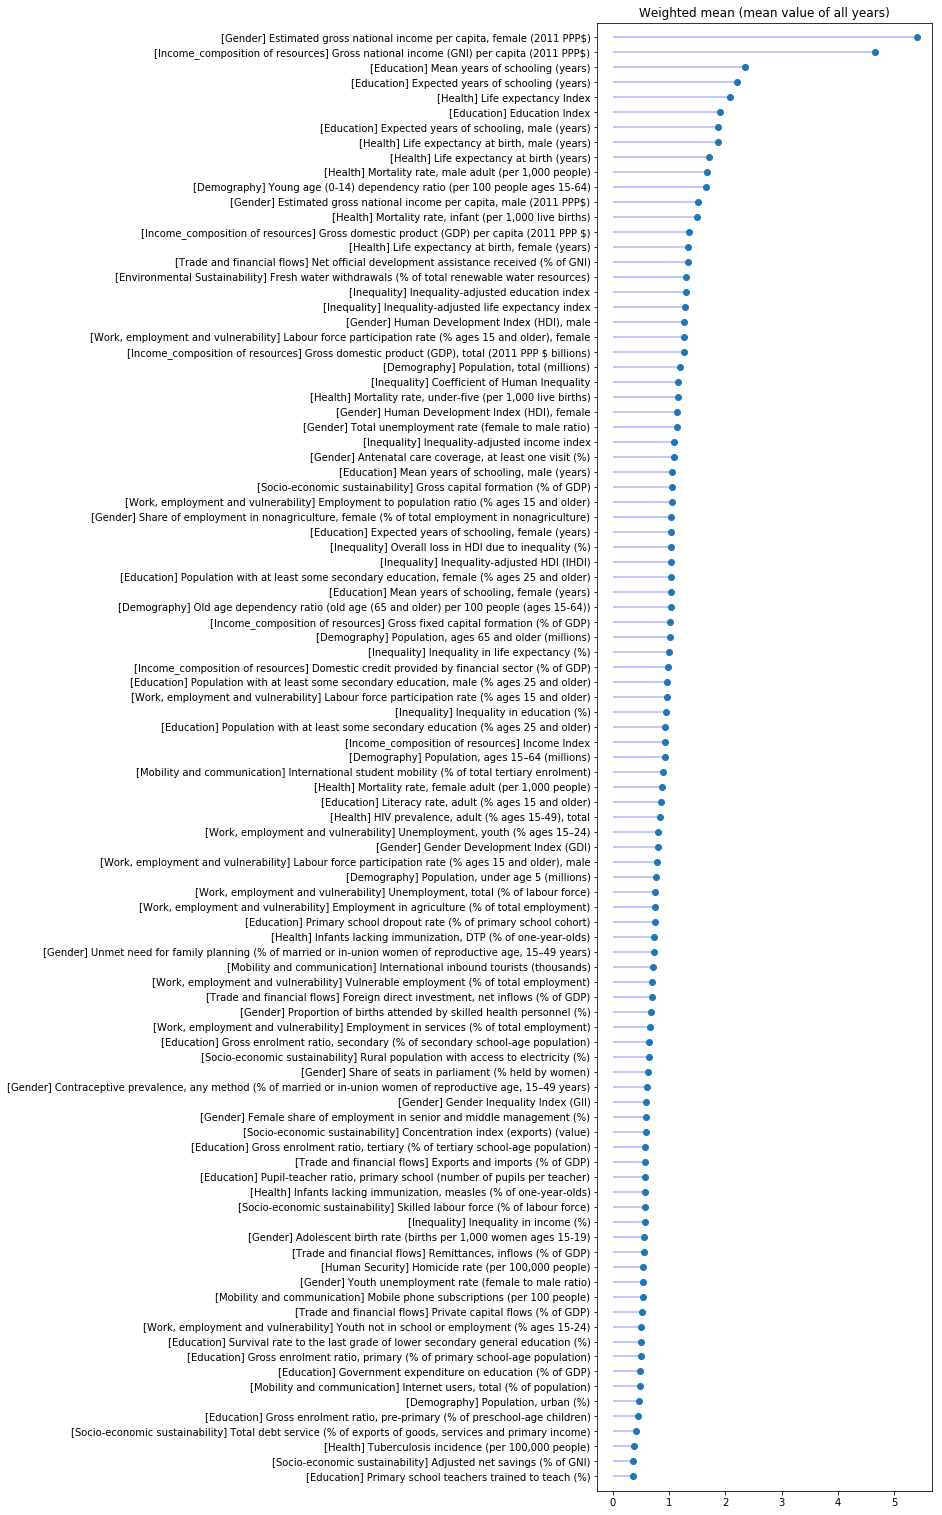

In [18]:
wmean_sorted_series = wmean_rel_df.mean(axis=1).sort_values()

plt.figure(figsize=(6, 27))
plt.plot(wmean_sorted_series.values, wmean_sorted_series.index, 'o')

for i in range(len(mean_sorted_series)):
    plt.hlines(i, xmin=0, xmax=wmean_sorted_series.iloc[i], alpha=0.3, color='blue')
    
plt.margins(0.05, 0.01)
plt.title('Weighted mean (mean value of all years)')
plt.savefig(f'{plot_out}/HDR_wmean_mean.png',
           bbox_inches=matplotlib.transforms.Bbox([[-8, 2.5], [6, 24.5]]))
plt.show()

##### Variance

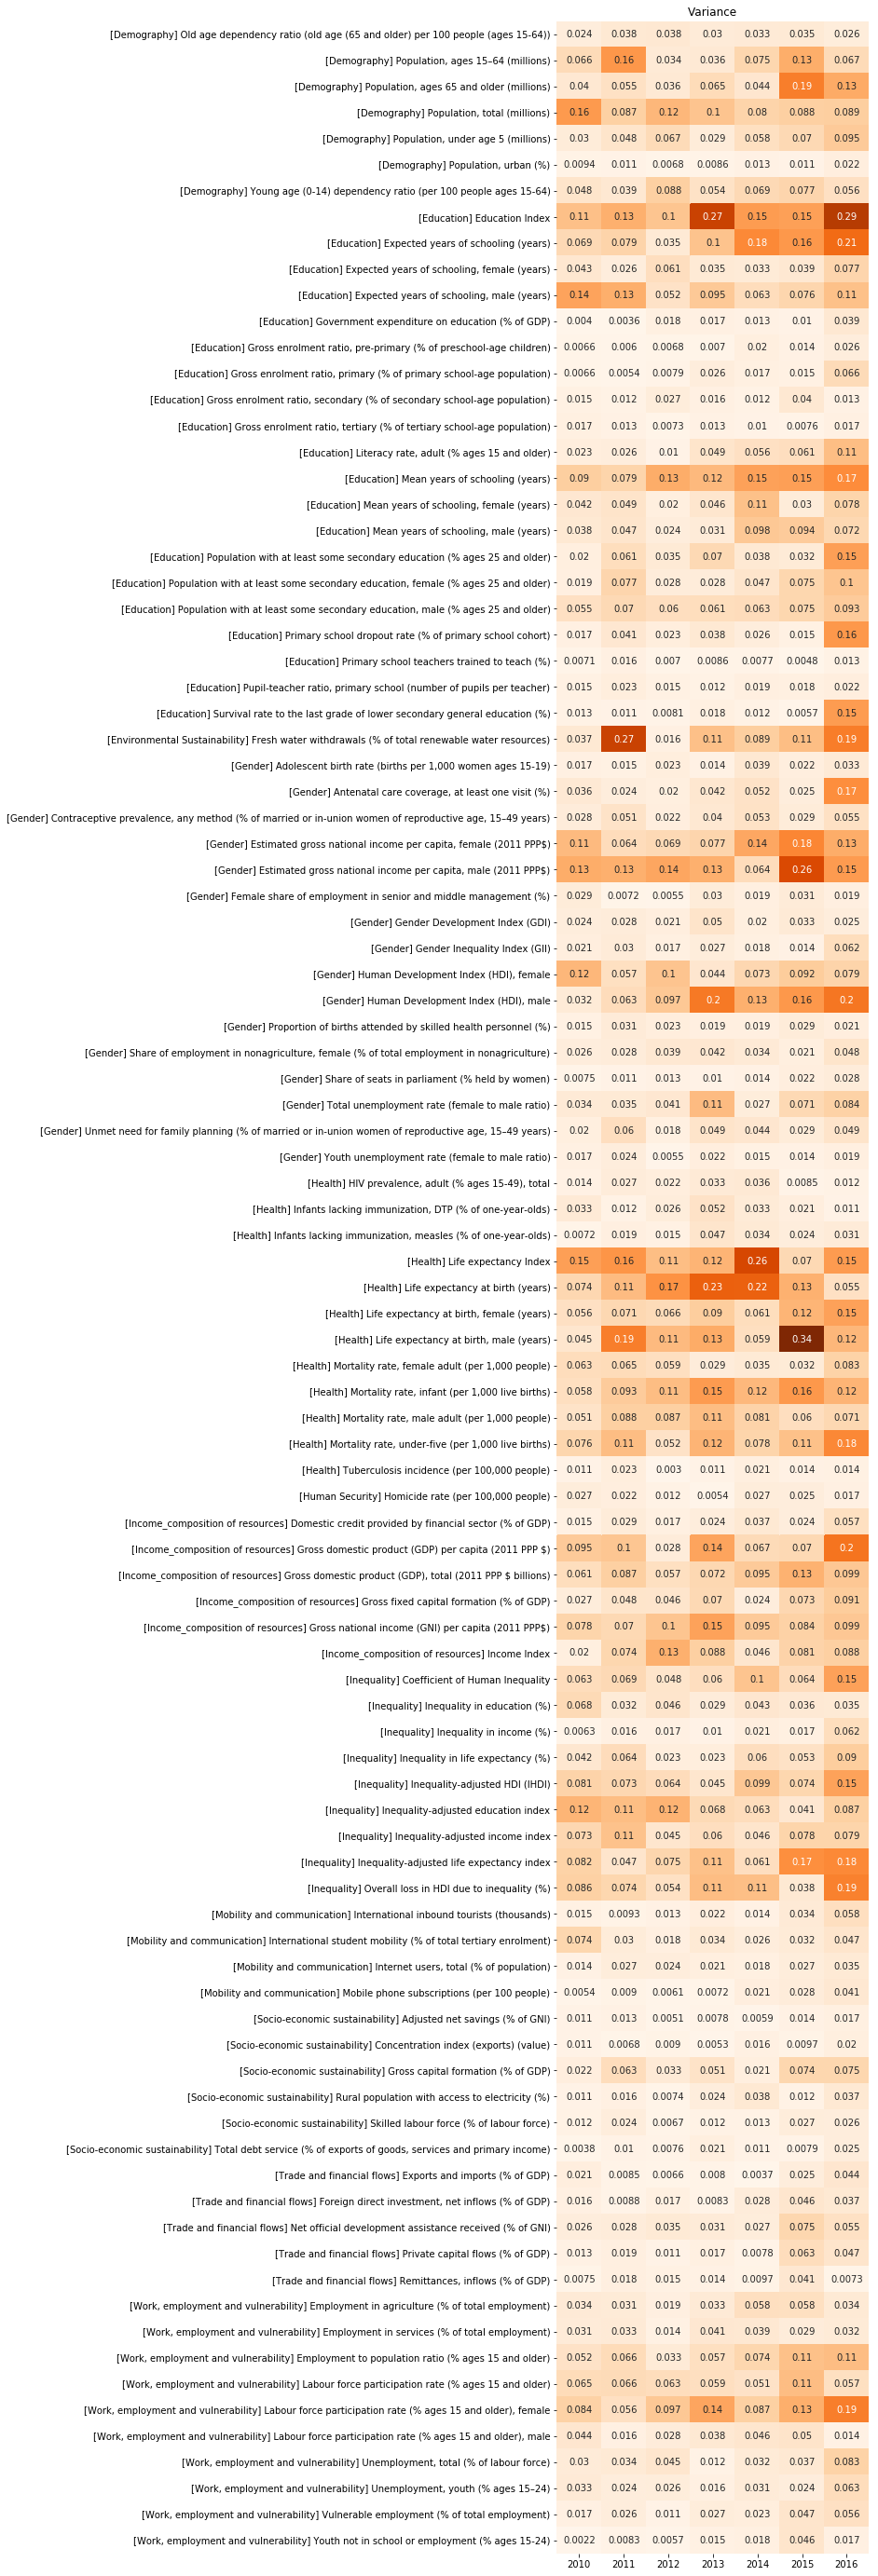

In [19]:
var_df = stats_df.filter(regex='Variance')
var_df.columns = years
var_df.to_csv(f'{data_out}/var.csv')

plt.figure(figsize=(6, 50))
seaborn.heatmap(var_df, annot=True, cbar=False, cmap='Oranges')
plt.title('Variance')
plt.savefig(f'{plot_out}/HDR_var.png',
            bbox_inches=matplotlib.transforms.Bbox([[-8, 5], [6, 45]]))
plt.show()

##### Skewness

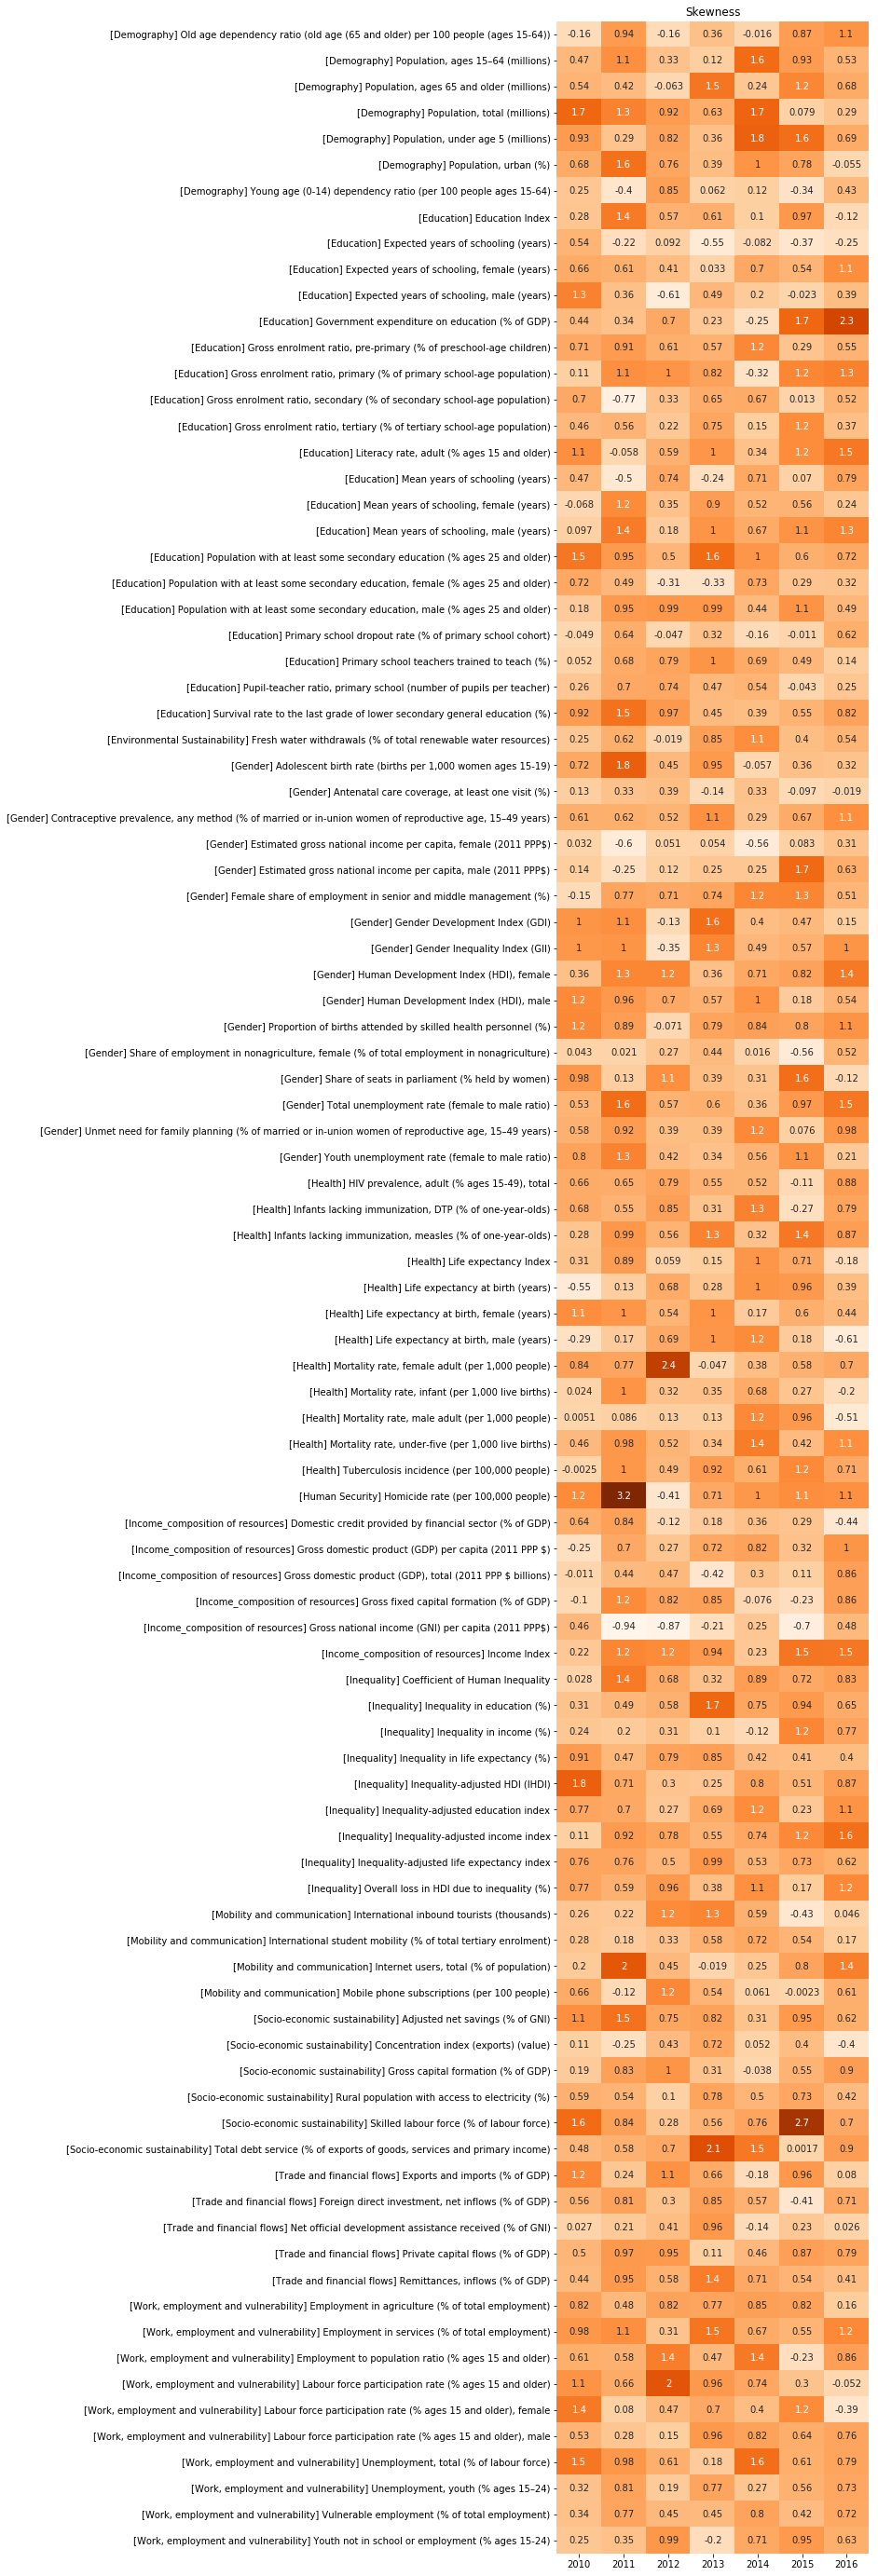

In [20]:
skew_df = stats_df.filter(regex='Skewness')
skew_df.columns = years
skew_df.to_csv(f'{data_out}/skew.csv')

plt.figure(figsize=(6, 50))
seaborn.heatmap(skew_df, annot=True, cbar=False, cmap='Oranges')
plt.title('Skewness')
plt.savefig(f'{plot_out}/HDR_skew.png',
            bbox_inches=matplotlib.transforms.Bbox([[-8, 5], [6, 45]]))
plt.show()

##### Sum of absolute differences between two consecutive years

In [21]:
mean_list   = list()
median_list = list() 
wmean_list  = list()

for year in years[:-1]:
    mean_list.append((mean_rel_df[year] - mean_rel_df[year+1]).abs().sum())
    median_list.append((median_rel_df[year] - median_rel_df[year+1]).abs().sum())
    wmean_list.append((wmean_rel_df[year] - wmean_rel_df[year+1]).abs().sum())

In [22]:
abs_diff_df = pd.concat([pd.Series(mean_list), pd.Series(median_list)], axis=1)  # , pd.Series(wmean_list)

##### Variances (Mean, Median, Weighted mean)

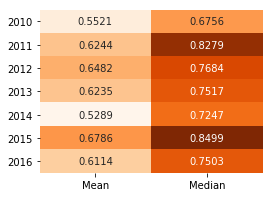

In [23]:
total_var = pd.concat([mean_rel_df.var(), median_rel_df.var()], axis=1)  # , wmean_rel_df.var()
total_var.columns = ['Mean', 'Median']  # , 'Weighted Mean'

plt.figure(figsize=(4, 3))
seaborn.heatmap(total_var, annot=True, cbar=False,
                           cmap='Oranges', fmt='.4f')
plt.show()

#### Plot weights of each attribute

#### <font style="color: #FF0000;">Warning: Slow operation!!!</font>

In [34]:
offset = 0.05
show = False

if not os.path.exists(f'{plot_out}/weight_series'):
    os.makedirs(f'{plot_out}/weight_series')

for i in range(90, 97):  # len(attr[1:])
    f, axs = plt.subplots(1, len(years), sharex='col', sharey='row', figsize=(20, 6))
    f.subplots_adjust(hspace=0, wspace=0)
    f.suptitle(f'{attr[i+1]}')
    
    if not show:
        print(f'{i+1:>3d}/{len(attr[1:]):>3d}: {attr[i+1]} ...', end=' ')
    
    for year in years:
        j = years.index(year)
    
        axs[j].plot(np.mean(W[year][:, i, :], axis=0), '-g')
        axs[j].plot(np.median(W[year][:, i, :], axis=0), '-m')
        axs[j].plot(W[year][:, i, :].T, '-r', alpha=0.2)
        if offset is not None:
            axs[j].set_ylim(bottom=W_min - offset, top=W_max + offset)
            
        axs[j].set_title(year)
        
        xticks = [int(x) for x in np.arange(0, n_iters+1, n_iters / 5)]
        axs[j].set_xticks(xticks)
        axs[j].set_xticklabels(xticks, rotation=90)
        
    f.legend(['Mean', 'Median', 'Weight'], loc=8, ncol=3)
    f.savefig(f'{plot_out}/weight_series/{attr[i+1]}.png',
              bbox_inches=matplotlib.transforms.Bbox([[2, -0.5], [18.5, 6]]))
    
    if show:
        plt.show()
    else:
        plt.close()
        print('Done!')

 91/ 97: [Work, employment and vulnerability] Labour force participation rate (% ages 15 and older) ... Done!
 92/ 97: [Work, employment and vulnerability] Labour force participation rate (% ages 15 and older), female ... Done!
 93/ 97: [Work, employment and vulnerability] Labour force participation rate (% ages 15 and older), male ... Done!
 94/ 97: [Work, employment and vulnerability] Unemployment, total (% of labour force) ... Done!
 95/ 97: [Work, employment and vulnerability] Unemployment, youth (% ages 15–24) ... Done!
 96/ 97: [Work, employment and vulnerability] Vulnerable employment (% of total employment) ... Done!
 97/ 97: [Work, employment and vulnerability] Youth not in school or employment (% ages 15-24) ... Done!


#### Analysis of the loss-function values

In [24]:
loss_df = dict()

for year in years:
    loss_df[year] = pd.DataFrame(C[year])

##### Loss-function statistics

In [25]:
loss_stats_df = pd.concat(
    [pd.DataFrame([loss_df[year][n_iters-1].min(),
                   loss_df[year][n_iters-1].max(),
                   loss_df[year][n_iters-1].mean(),
                   loss_df[year][n_iters-1].median(),
                   loss_df[year][n_iters-1].var()],
                   index=['Minimum', 'Maximum', 'Mean',
                          'Median', 'Variance']).transpose()
     for year in years]
)
loss_stats_df.index = years
loss_stats_df  # .style.background_gradient(cmap='Oranges')

Minimum       Maximum          Mean        Median      Variance
2010  2.468097e-14  1.165391e-11  1.715330e-12  2.277824e-13  1.102654e-23
2011  1.003210e-14  2.158472e-12  8.580397e-13  7.761765e-13  4.428413e-25
2012  5.561100e-15  3.836329e-13  6.511198e-14  2.263483e-14  7.725421e-27
2013  1.113464e-11  3.621733e-10  8.122043e-11  5.888019e-11  6.421618e-21
2014  4.436849e-12  2.702221e-10  1.108512e-10  9.178308e-11  7.476801e-21
2015  1.136551e-10  3.609149e-09  7.477233e-10  5.027842e-10  5.765244e-19
2016  3.705324e-09  4.610196e-08  1.225636e-08  8.815870e-09  1.326528e-16

##### Plot (iteration, loss function value)

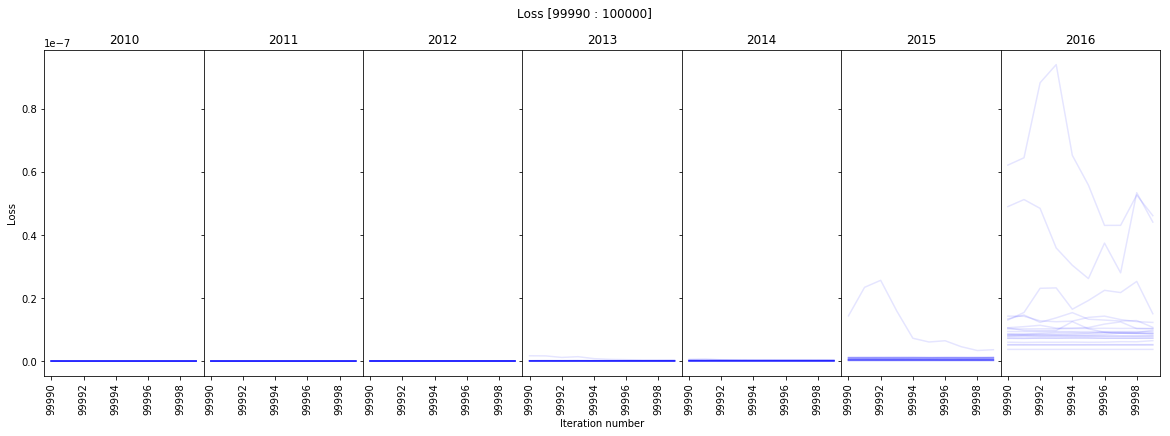

In [26]:
alpha = 0.1
last_iters = 99990

f, axs = plt.subplots(1, len(years), sharex='all', sharey='all', figsize=(20, 6))
f.subplots_adjust(hspace=0, wspace=0)
f.suptitle(f'Loss [{last_iters} : {C[year].shape[1]}]')

if not os.path.exists(f'{plot_out}/loss'):
    os.makedirs(f'{plot_out}/loss')
    
axs[0].set_ylabel('Loss')
axs[3].set_xlabel('Iteration number')

for year in years:
#     loss = {s: pd.DataFrame(y[year][s], index=t[year].index).subtract(t[year], axis=0).pow(2).divide(2).mean()
#             for s in range(W[year].shape[0])}
    j = years.index(year)

    axs[j].plot(C[year][:, last_iters:].T, '-b', alpha=alpha)
    axs[j].set_title(year)
#     axs[j].set_xticks(np.arange(last_iters-2, n_iters+1, 2))
    axs[j].set_xticklabels(np.arange(last_iters-2, n_iters+1, 2), rotation=90)

    plt.figure(figsize=(16, 9))
    plt.plot(C[year][:, last_iters:].T, '-b', alpha=alpha)
    plt.title(f'Loss ({year} [{last_iters} : {C[year].shape[1]}])')
    plt.savefig(f'{plot_out}/loss/{last_iters}_{C[year].shape[1]}_{year}')
    plt.close()

f.savefig(f'{plot_out}/HDR_loss.png',
          bbox_inches=matplotlib.transforms.Bbox([[2, -0.5], [18.5, 6]]))

plt.show()